In [251]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
matplotlib.rcParams["figure.dpi"] = 1000
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

## Monthly data

In [262]:
xm = []
ym = []
for j in range(1976,2024):
    with open(r"Flare Index Dataset Cleaner\\"+str(j)+".txt", mode="r") as f:
        lines = f.readlines()
        line = lines[-3].strip()
        for v in line.split("\t")[1:]:
            ym.append(float(v))
        for i in range(12):
            xm.append(j+1.00*i/12.00)

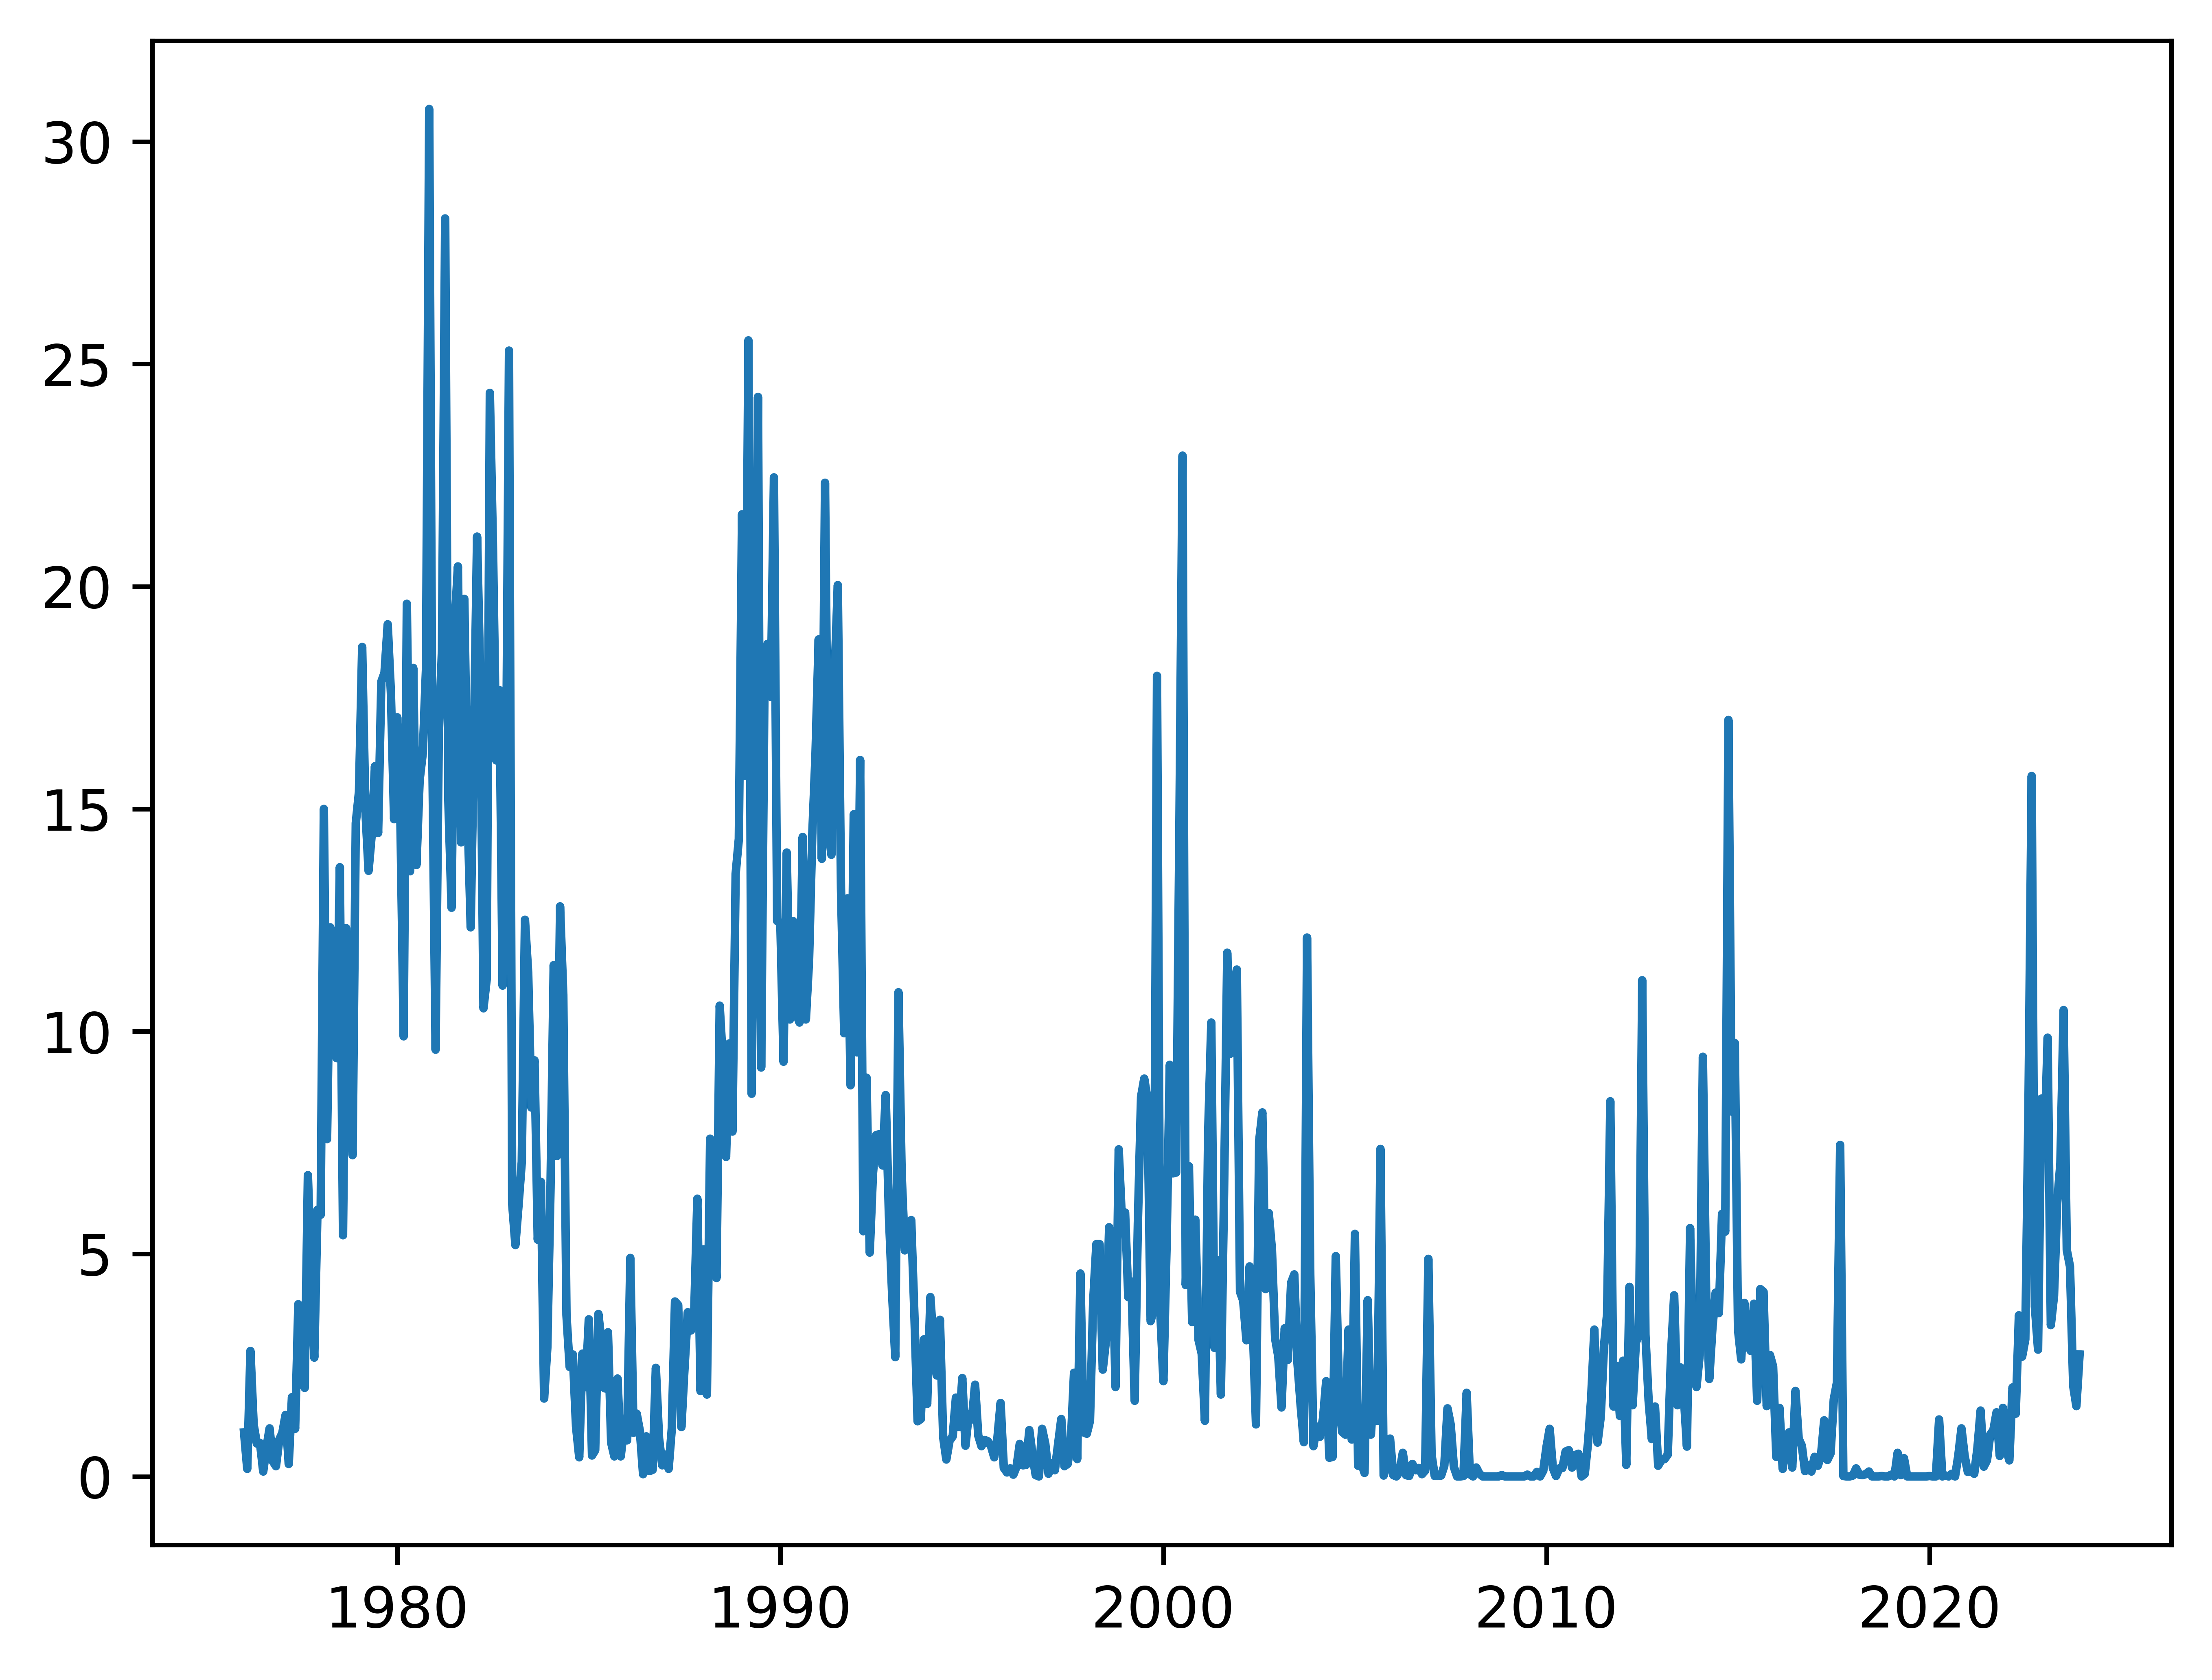

In [263]:
plt.plot(xm,ym)

## Daily

In [404]:
x = []
y = []
ymstd = [] #y std monthly
for j in range(1976,2024):
    with open(r"Flare Index Dataset Cleaner\\"+str(j)+".txt", mode="r") as f:
        lines = f.readlines()[7:]
        mat = []
        for line in lines[:-4]:
            if line[0] == '\n': continue
            l = line.split("\t")
            l[-1] = l[-1].strip()
            for i in range(len(l)):
                if l[i] == '': l[i] = -1
                l[i] = float(l[i])
            mat.append(l[1:13])
        mat = np.matrix(mat).transpose() #reordering
        #calculate variance and +- 1*sigma values per month
        for v in mat:
            v = v.tolist()[0]
            v = [i for i in v if i >= 0]
            ymstd.append(np.std(v))
        days = mat.flatten().tolist()[0] #turn it into a 1D array
        days = [i for i in days if i >= 0]
        ndays = len(days)
        for i in range(ndays):
            y.append(days[i])
            x.append(j+1.00*i/(ndays*1.00))

In [405]:
#extra calculations for upper and lower bounds
ns = 1 #number of sigmas. Default is 1.
yupp = np.array(ym)+ns*np.array(ymstd)
ylow = np.array(ym)-ns*np.array(ymstd)
zeros = np.ndarray(ylow.shape)
def ylowhelper(i):
    if i<0: return 0
    else: return i
vctrd = np.vectorize(ylowhelper)
ylow = vctrd(ylow)

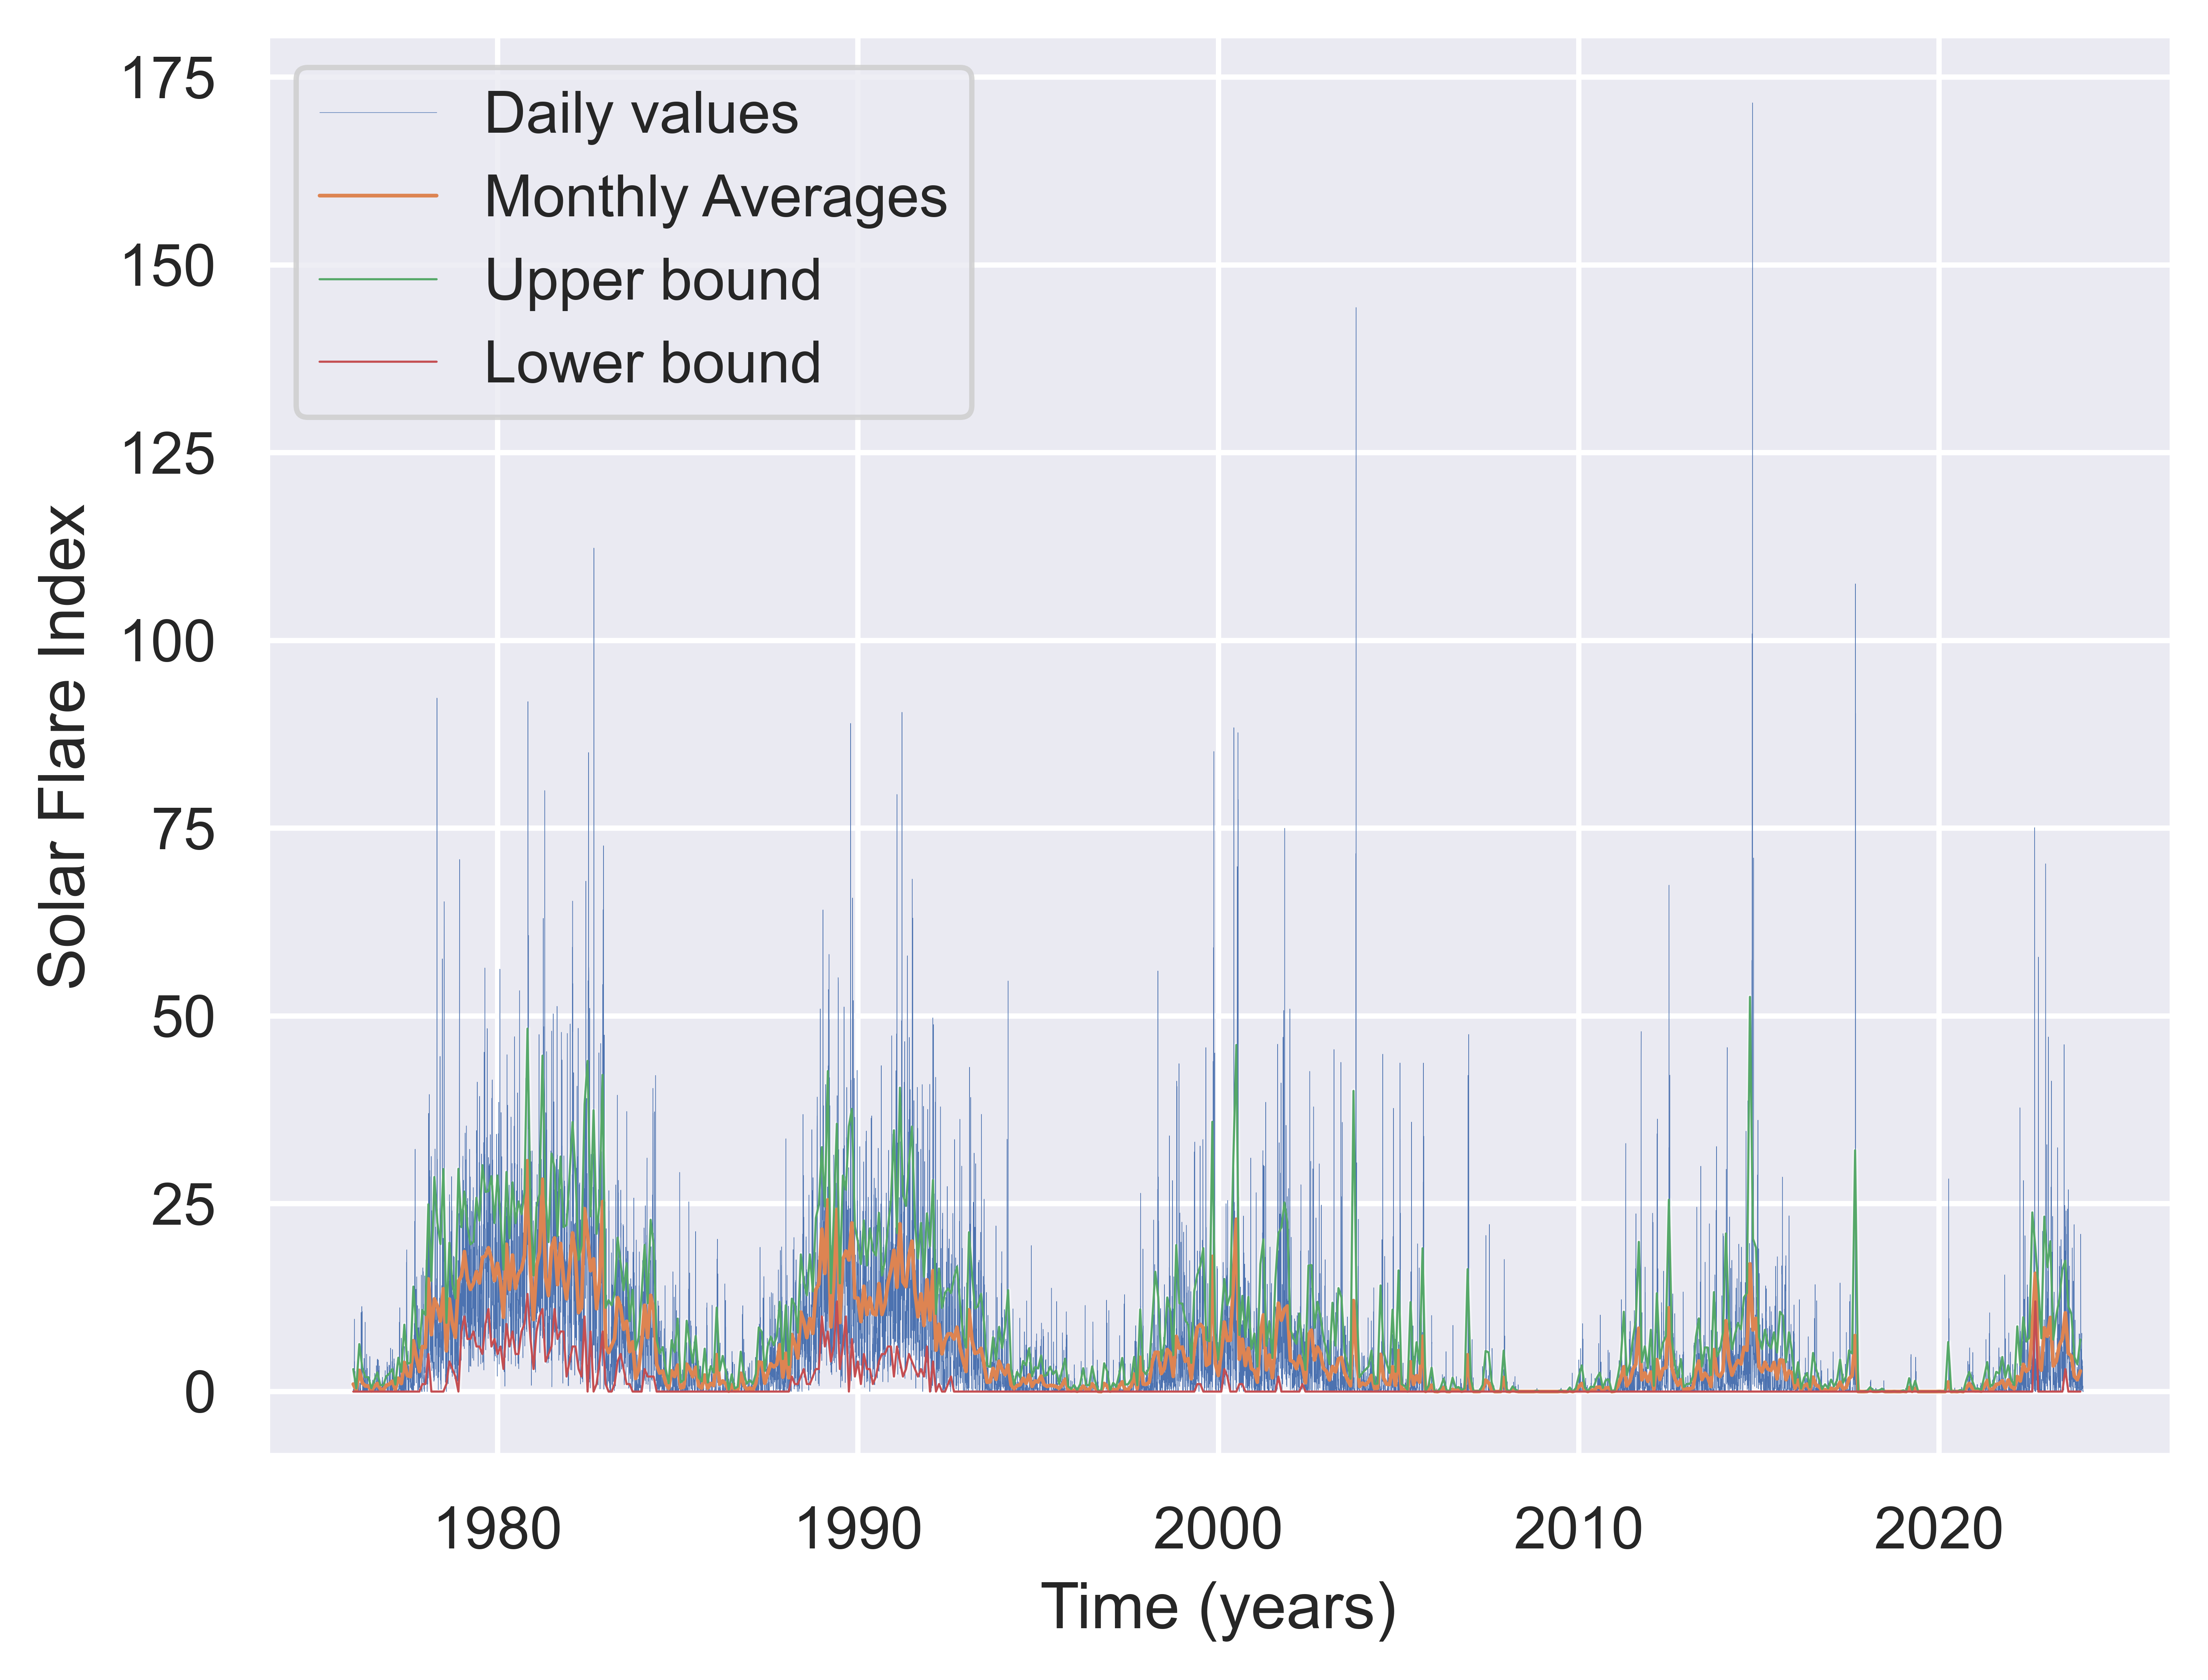

In [422]:
fig, ax = plt.subplots()
sns.lineplot(x=x,y=y,lw=0.1,label="Daily values")
sns.despine()
sns.lineplot(x=xm,y=ym,lw=0.7,label="Monthly Averages")
sns.lineplot(x=xm,y=yupp,lw=0.4,label="Upper bound")
sns.lineplot(x=xm,y=ylow,lw=0.4,label="Lower bound")
plt.fill_between(x=xm,y1=ylow,y2=yupp,color='white', alpha=0.5) #TODO
sns.set(font_scale=1)
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.legend()
plt.savefig('daily_variations.png', dpi=2000, bbox_inches='tight')
plt.show()

## Time series modelling
### ARMA

In [208]:
# Check for stationality (Dickey-Fuller ADF test)
t = adfuller(ym)
print('ADF Statistic:', t[0])
print('p-value:', t[1]) #we obtain p>0.05, but close to it. 
#But if we look into the daily series...
t = adfuller(y)
print('ADF Statistic:', t[0])
print('p-value:', t[1]) #we obtain p<<<0.05. So we will consider ym to also be stationary.

ADF Statistic: -2.5564019461976297
p-value: 0.10234697783906815
ADF Statistic: -7.485723626428135
p-value: 4.6448248439848e-11


In [224]:
def get_loglike(v):
    b = v.as_csv().split("\n")
    b = b[2].split(",")[-1]
    return float(b)

In [235]:
model = ARIMA(ym, order=(1, 0, 1))
model_fit = model.fit()
# Print the model summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  576
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1466.460
Date:                Fri, 27 Dec 2024   AIC                           2940.921
Time:                        16:08:12   BIC                           2958.345
Sample:                             0   HQIC                          2947.716
                                - 576                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5067      3.235      1.393      0.164      -1.834      10.847
ar.L1          0.9805      0.008    120.845      0.000       0.965       0.996
ma.L1         -0.6681      0.023    -28.536      0.000      -0.714      -0.622
sigma2         9.4976      0.355     26.767      0.000       8.802      10.193
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):               542.34
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
print(get_loglike(model_fit.summary()))

In [258]:
def generate_months_pred(n,last_date):
    months_pred = n
    start = len(ym)
    end = start + months_pred-1
    xpred = []
    for i in range(months_pred):
        xpred.append(last_date+i/12)
    return xpred

In [249]:
predictions = model_fit.predict(start=start, end=end)

<Axes: >

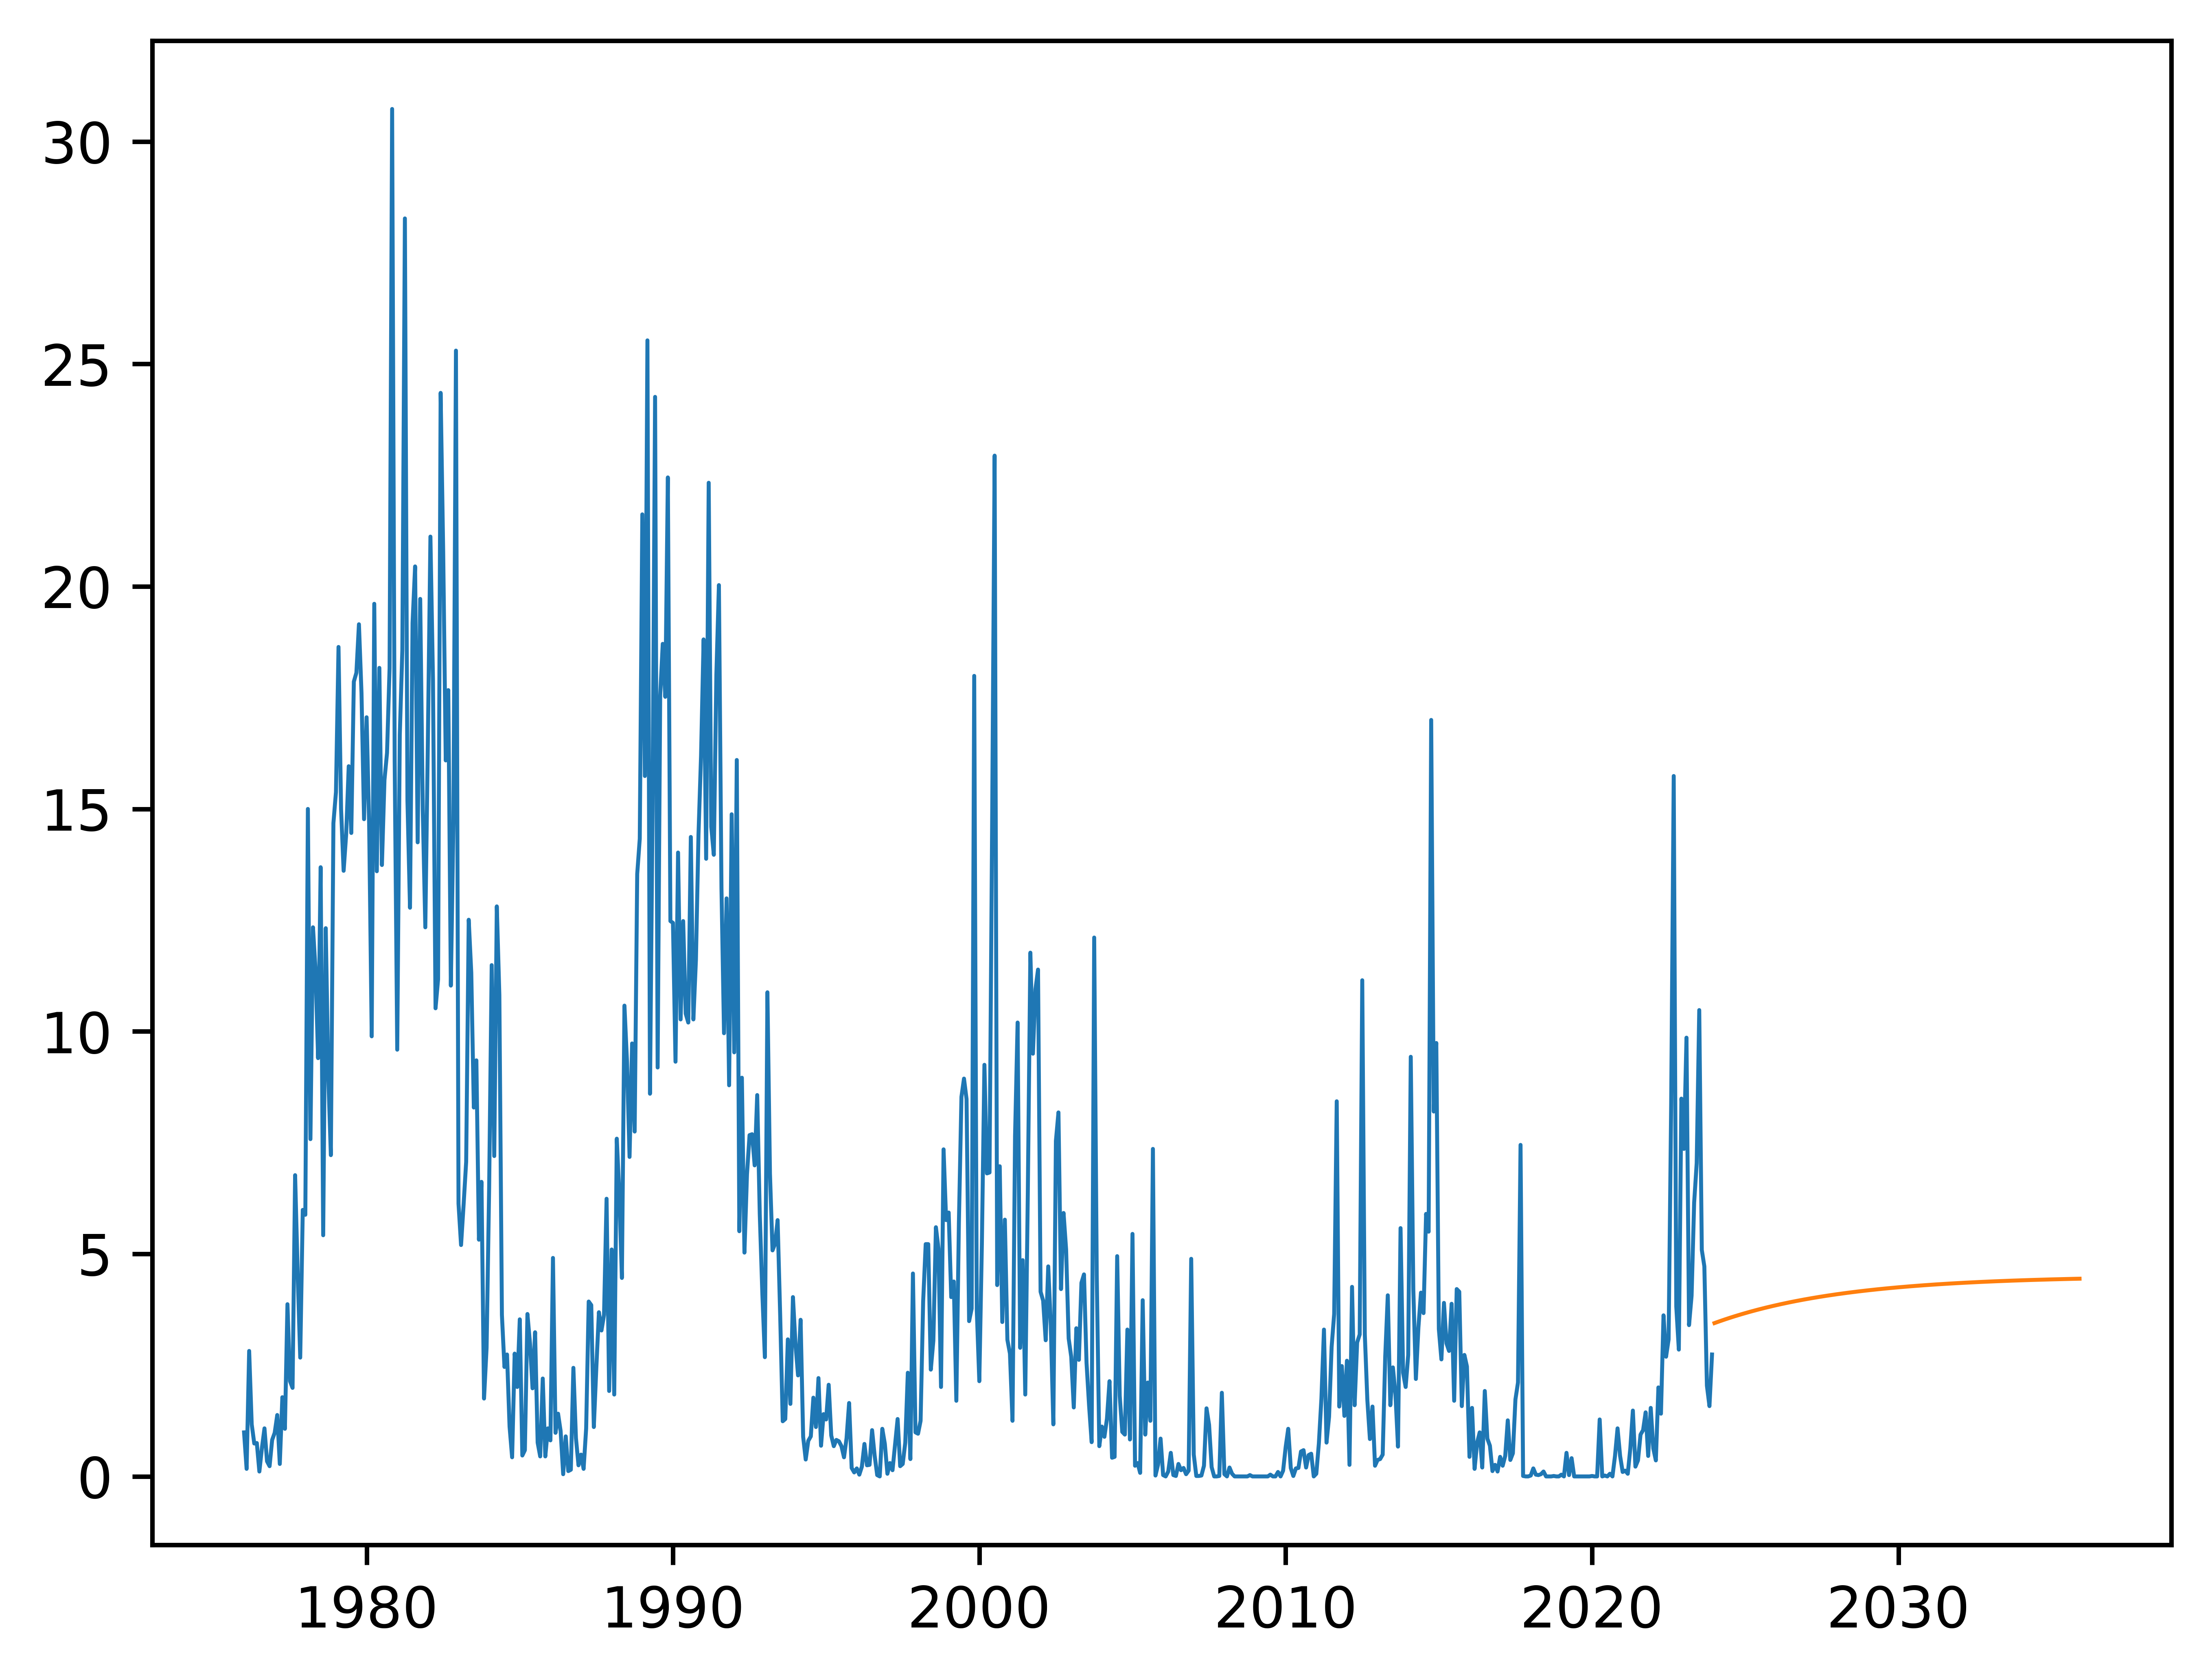

In [250]:
sns.lineplot(x=xm,y=ym,lw=0.7)
len(xpred)
len(predictions)
sns.lineplot(x=xpred,y=predictions,lw=0.7)

### SARIMA

In [310]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12*11  # Assuming 11 year seasonality

# Fit the SARIMA model
model = SARIMAX(ym, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

C:\Users\Nero\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [311]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  576
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 132)   Log Likelihood               -1223.597
Date:                             Fri, 27 Dec 2024   AIC                           2457.195
Time:                                     17:00:41   BIC                           2477.663
Sample:                                          0   HQIC                          2465.267
                                             - 576                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1277      0.048      2.651      0.008       0.033       0.222
ma.L1         -0.7807      

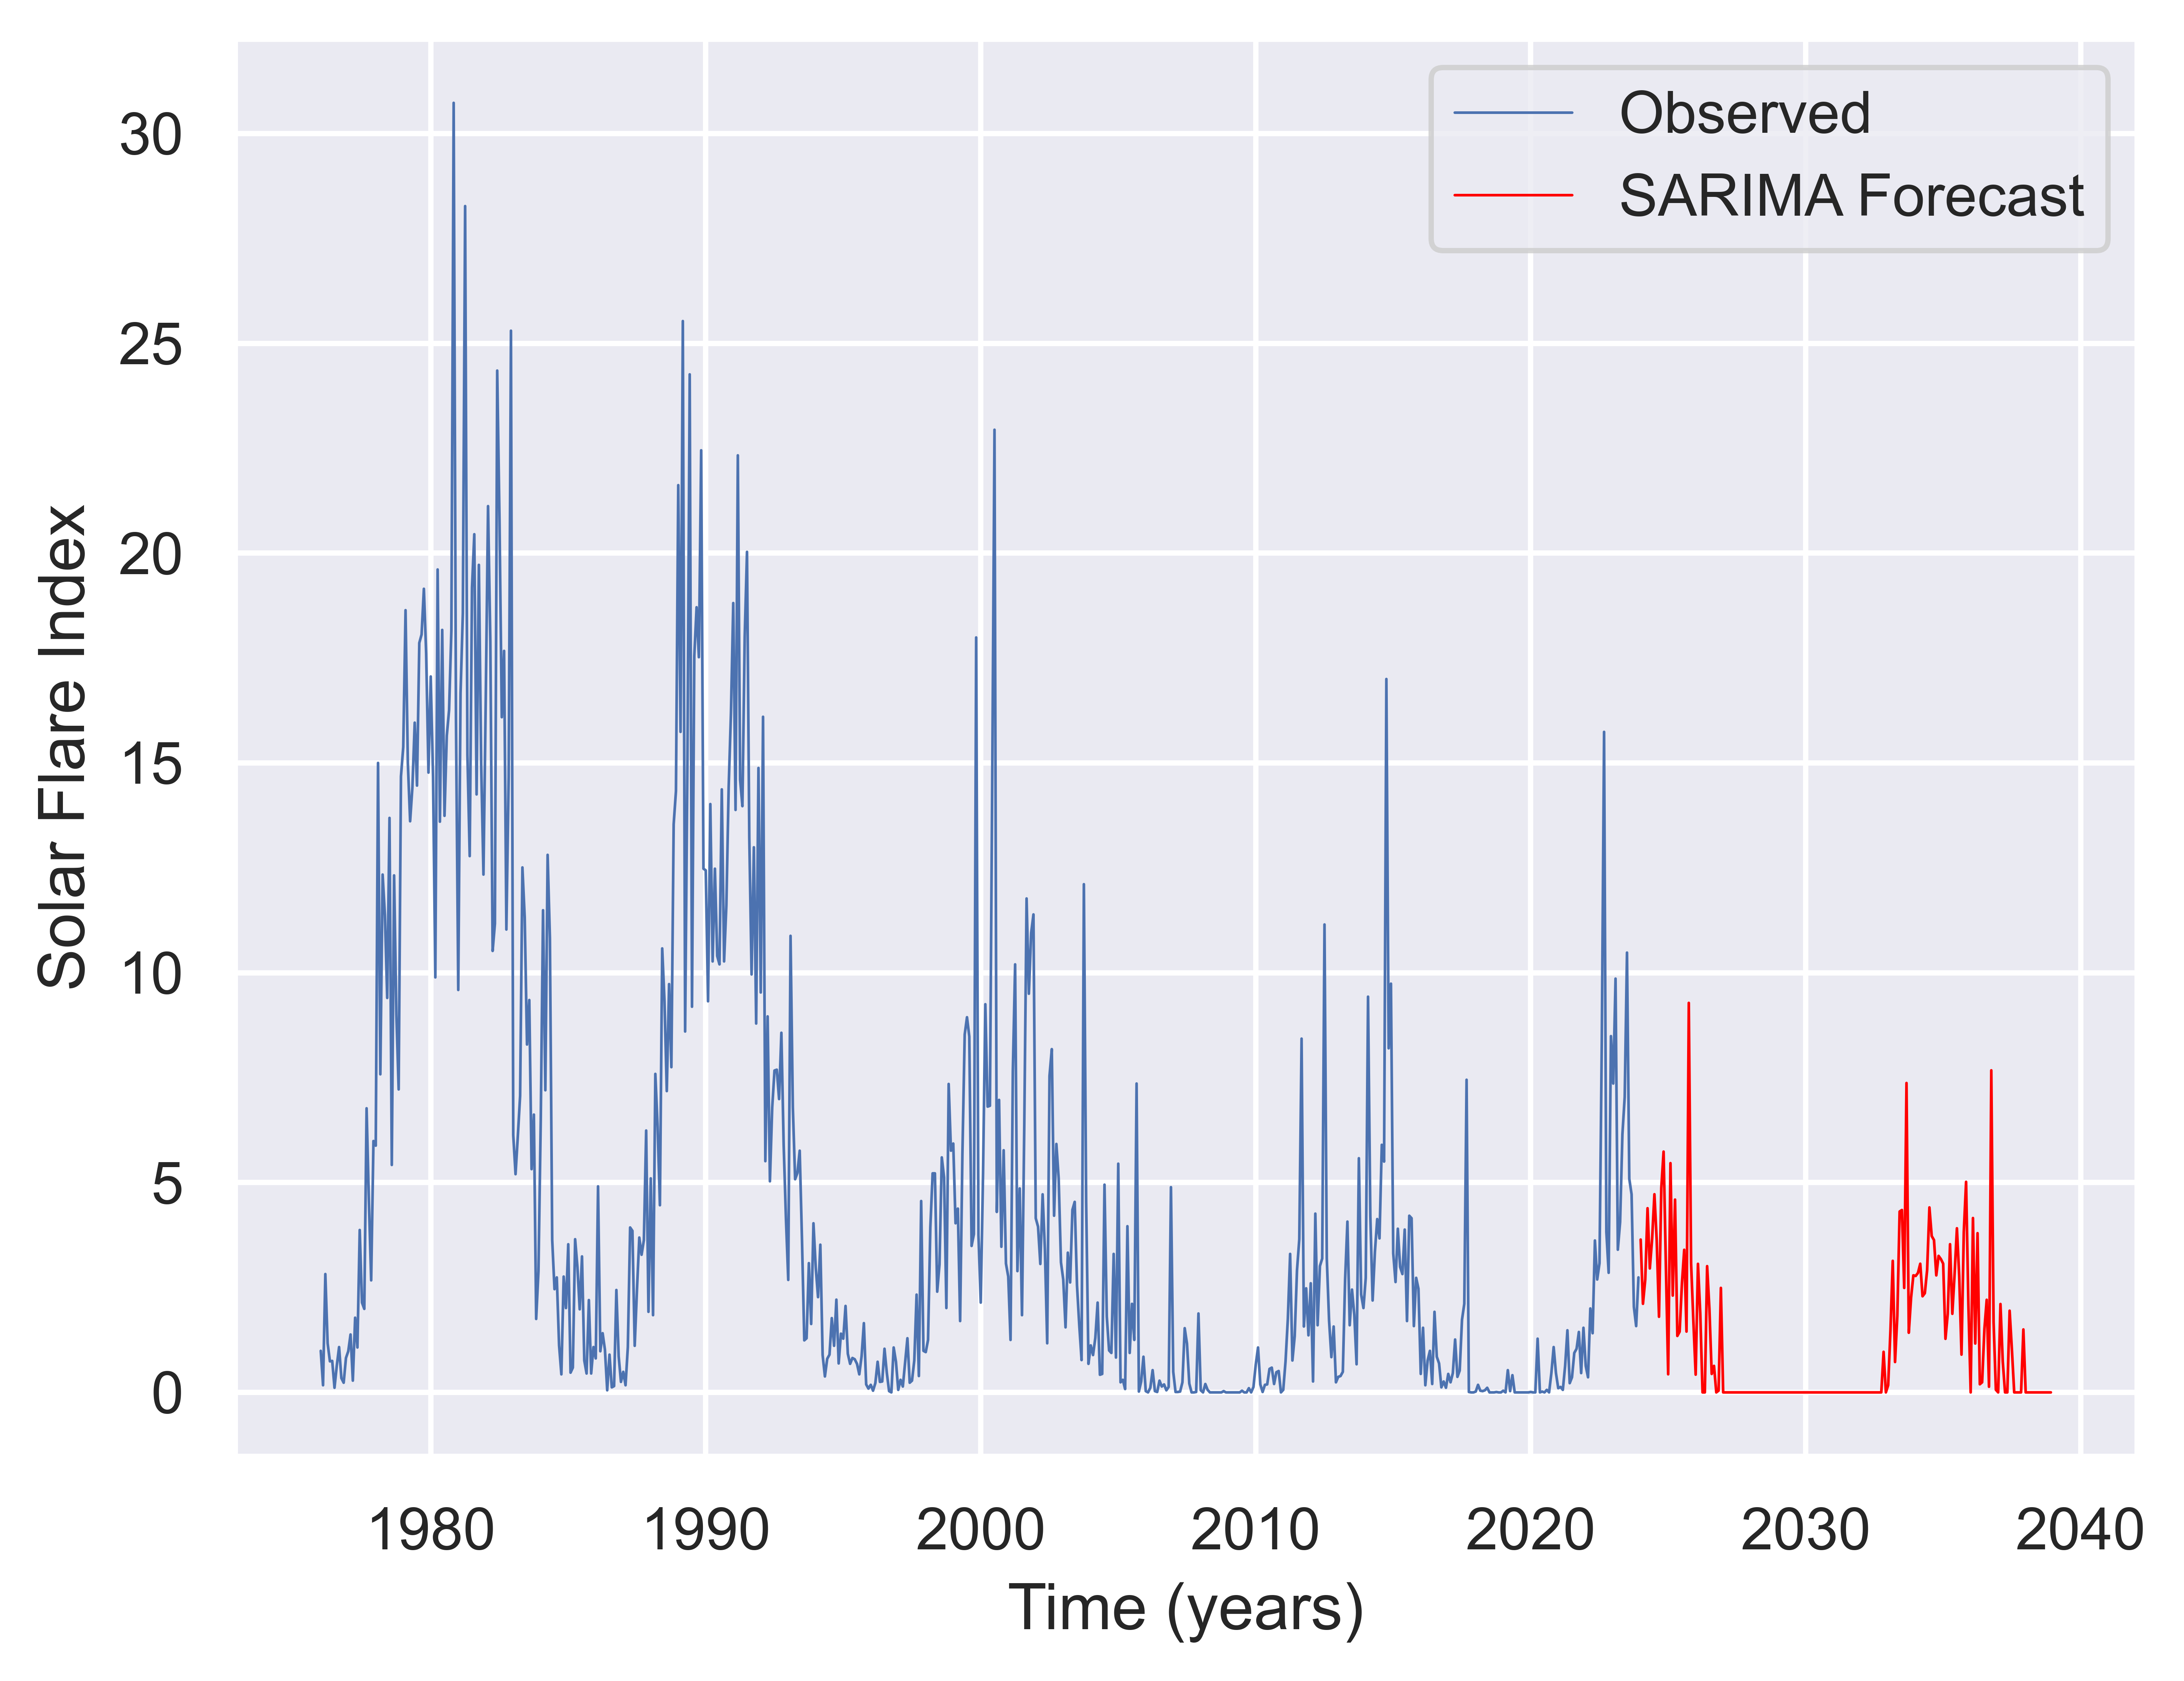

In [426]:
# Forecast future values
forecast_periods = 12*15  # Forecast the next 15 years
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
fclow = vctrd(forecast_ci.transpose()[0])
fcupp = forecast_ci.transpose()[1]

xmnew = generate_months_pred(forecast_periods, x[-1])

# Plot the forecast
fig, ax = plt.subplots()
sns.lineplot(x=xm, y=ym, label='Observed',lw=0.5)
sns.lineplot(x=xmnew, y=vctrd(forecast_mean), label='SARIMA Forecast', color='red',lw=0.5)
#plt.fill_between(xmnew, fclow, fcupp, color='pink')
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.legend()
plt.savefig('SARIMA.png', dpi=2000, bbox_inches='tight')
plt.show()

## Mathematical model approximation

In [428]:
def mat_model(xi):
    #args1
    A=7.5
    w=11
    off=1976
    off2=6.3
    #args2
    w2=w*8
    A2=0.5
    B2=0.2
    off3=-6
    #overall
    alpha = 1/16
    return alpha*((A+np.cos((xi-off+off2)*2*np.pi/w)*A)**2)*(B2+A2+np.cos((xi-off+off3)*2*np.pi/w2)*A2)
v2 = np.vectorize(mat_model)

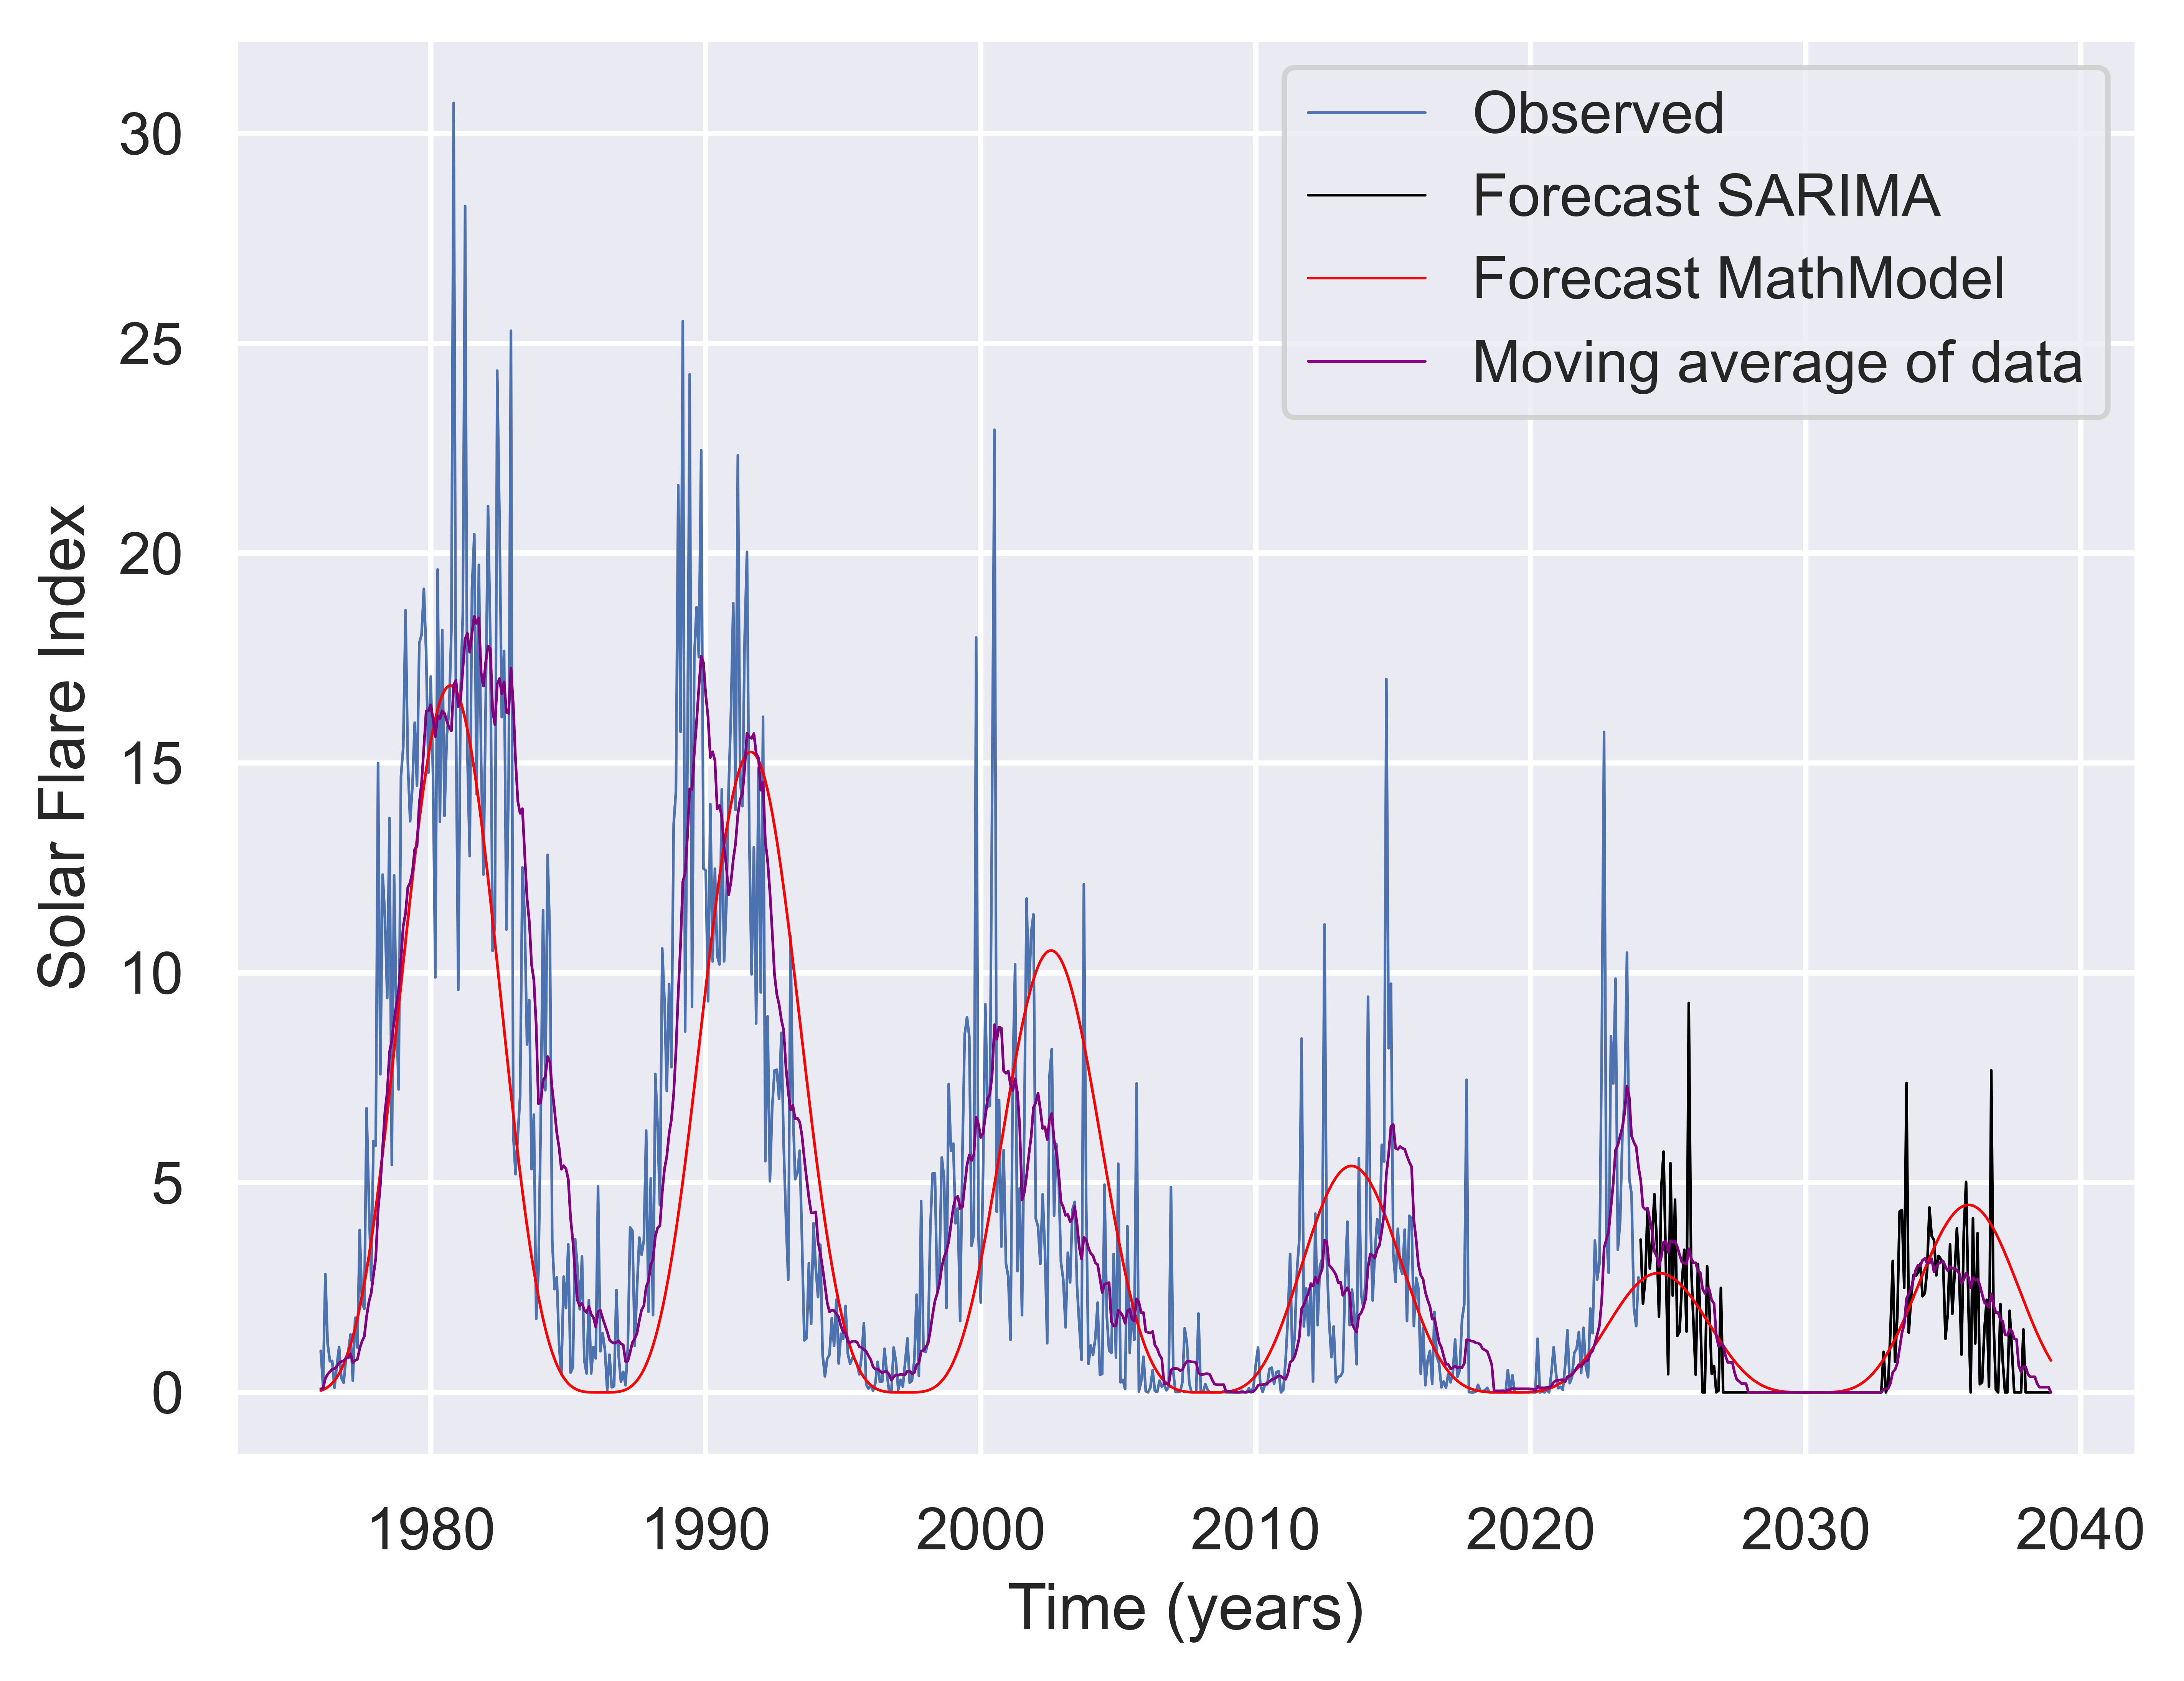

In [429]:
# Plot everything together
fig, ax = plt.subplots()
sns.lineplot(x=xm, y=ym, label='Observed',lw=0.5)
sns.lineplot(x=xmnew, y=vctrd(forecast_mean), label='Forecast SARIMA', color='black',lw=0.5)
sns.lineplot(x=xm+xmnew, y=v2(xm+xmnew), label='Forecast MathModel', color='red',lw=0.5)
MA_size=12
sns.lineplot(x=(xm+xmnew), y=np.convolve(ym+vctrd(forecast_mean).tolist(),np.ones(MA_size)/MA_size)[:-MA_size+1], label='Moving average of data', color='purple',lw=0.5)
#plt.fill_between(xmnew, fclow, fcupp, color='pink')
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.legend()
plt.savefig('MathModel.png', dpi=2000, bbox_inches='tight')
plt.show()

In [390]:
print(len(np.convolve(v2(xm+xmnew),np.ones(6)/6)[:-5]))
print(len(xm+xmnew))

756
756
